# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
from workspace_utils import active_session

In [2]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
                            # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import torch.optim as optim
from torch import nn
import torch
from collections import deque
import torch.nn.functional as F
!pip install progressbar
import progressbar as pb

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 



In [36]:
import os
import torch
import torch.nn.functional as F
import torch.distributed as dist
from torch.autograd import Variable
import numpy as np

def transpose_list(mylist):
    return list(map(list, zip(*mylist)))

def transpose_to_tensor(input_list):
    make_tensor = lambda x: torch.tensor(x, dtype=torch.float)
    return list(map(make_tensor, zip(*input_list)))


# https://github.com/ikostrikov/pytorch-ddpg-naf/blob/master/ddpg.py#L11
def soft_update(target, source, tau):
    """
    Perform DDPG soft update (move target params toward source based on weight
    factor tau)
    Inputs:
        target (torch.nn.Module): Net to copy parameters to
        source (torch.nn.Module): Net whose parameters to copy
        tau (float, 0 < x < 1): Weight factor for update
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

# https://github.com/ikostrikov/pytorch-ddpg-naf/blob/master/ddpg.py#L15
def hard_update(target, source):
    """
    Copy network parameters from source to target
    Inputs:
        target (torch.nn.Module): Net to copy parameters to
        source (torch.nn.Module): Net whose parameters to copy
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

# https://github.com/seba-1511/dist_tuto.pth/blob/gh-pages/train_dist.py
def average_gradients(model):
    """ Gradient averaging. """
    size = float(dist.get_world_size())
    for param in model.parameters():
        dist.all_reduce(param.grad.data, op=dist.reduce_op.SUM, group=0)
        param.grad.data /= size

# https://github.com/seba-1511/dist_tuto.pth/blob/gh-pages/train_dist.py
def init_processes(rank, size, fn, backend='gloo'):
    """ Initialize the distributed environment. """
    os.environ['MASTER_ADDR'] = '127.0.0.1'
    os.environ['MASTER_PORT'] = '29500'
    dist.init_process_group(backend, rank=rank, world_size=size)
    fn(rank, size)

def onehot_from_logits(logits, eps=0.0):
    """
    Given batch of logits, return one-hot sample using epsilon greedy strategy
    (based on given epsilon)
    """
    # get best (according to current policy) actions in one-hot form
    argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()
    if eps == 0.0:
        return argmax_acs
    # get random actions in one-hot form
    rand_acs = Variable(torch.eye(logits.shape[1])[[np.random.choice(
        range(logits.shape[1]), size=logits.shape[0])]], requires_grad=False)
    # chooses between best and random actions using epsilon greedy
    return torch.stack([argmax_acs[i] if r > eps else rand_acs[i] for i, r in
                        enumerate(torch.rand(logits.shape[0]))])

# modified for PyTorch from https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
    """Sample from Gumbel(0, 1)"""
    U = Variable(tens_type(*shape).uniform_(), requires_grad=False)
    return -torch.log(-torch.log(U + eps) + eps)

# modified for PyTorch from https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
def gumbel_softmax_sample(logits, temperature):
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data))
    return F.softmax(y / temperature, dim=1)

# modified for PyTorch from https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
def gumbel_softmax(logits, temperature=0.5, hard=False):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
      logits: [batch_size, n_class] unnormalized log-probs
      temperature: non-negative scalar
      hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
      [batch_size, n_class] sample from the Gumbel-Softmax distribution.
      If hard=True, then the returned sample will be one-hot, otherwise it will
      be a probabilitiy distribution that sums to 1 across classes
    """
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        y_hard = onehot_from_logits(y)
        y = (y_hard - y).detach() + y
    return y



In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Network(nn.Module):
    def __init__(self, input_dim, output_dim, actor=False):
        super(Network, self).__init__()

        """self.input_norm = nn.BatchNorm1d(input_dim)
        self.input_norm.weight.data.fill_(1)
        self.input_norm.bias.data.fill_(0)"""

        self.fc1 = nn.Linear(input_dim,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,output_dim)
        self.nonlin = f.relu #leaky_relu
        self.actor = actor
        #self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-1e-3, 1e-3)

    def forward(self, x):
        if self.actor:
            # return a vector of the force
            h1 = self.nonlin(self.fc1(x))

            h2 = self.nonlin(self.fc2(h1))
            h3 = (self.fc3(h2))
            norm = torch.norm(h3)
            
            # h3 is a 2D vector (a force that is applied to the agent)
            # we bound the norm of the vector to be between 0 and 10
            return 10.0*(f.tanh(norm))*h3/norm if norm > 0 else 10*h3
        
        else:
            # critic network simply outputs a number
            h1 = self.nonlin(self.fc1(x))
            h2 = self.nonlin(self.fc2(h1))
            h3 = (self.fc3(h2))
            return h3

In [38]:
from collections import deque
import random


class ReplayBuffer:
    def __init__(self,size):
        self.size = size
        self.deque = deque(maxlen=self.size)

    def push(self,transition):
        """push into the buffer"""
        
        #input_to_buffer = transpose_list(transition)
        #for item in input_to_buffer:
        #    self.deque.append(item)
        self.deque.append(transition)
    def sample(self, batchsize):
        """sample from the buffer"""
        samples = random.sample(self.deque, batchsize)
        states = []
        actions = []
        next_states = []
        rewards = []
        dones = []
        for i in samples:
            state,action,reward,next_state,done = i[0],i[1],i[2],i[3],i[4]
            states.append(state)
            actions.append(action)
            next_states.append(next_state)
            dones.append(done)
            rewards.append(reward)
        # transpose list of list
        return states,actions,rewards,next_states,dones
        #return samples
    def __len__(self):
        return len(self.deque)






In [39]:
import numpy as np
import torch


# from https://github.com/songrotek/DDPG/blob/master/ou_noise.py
class OUNoise:

    def __init__(self, action_dimension, scale=0.1, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return torch.tensor(self.state * self.scale).float()

In [40]:
# individual network settings for each actor + critic pair
# see networkforall for details

from torch.optim import Adam
import torch
import numpy as np


# add OU noise for exploration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DDPGAgent:
    def __init__(self, state_size,action_size, lr_actor=1.0e-2, lr_critic=1.0e-2):
        super(DDPGAgent, self).__init__()

        self.actor = Network(state_size,action_size, actor=True).to(device)
        self.critic = Network(state_size+action_size,1, actor=False).to(device)
        self.target_actor = Network(state_size,action_size, actor=True).to(device)
        self.target_critic = Network(state_size+action_size,1, actor=False).to(device)

        self.noise = OUNoise(action_size, scale=1.0 )

        
        # initialize targets same as original networks
        hard_update(self.target_actor, self.actor)
        hard_update(self.target_critic, self.critic)

        self.actor_optimizer = Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=lr_critic, weight_decay=1.e-5)


    def act(self, obs, noise=0.0):
        #obs = torch.from_numpy(obs).float().to(device)
        action = self.actor(obs) + noise*self.noise.noise()
        return action

    def target_act(self, obs, noise=0.0):
        #obs = torch.from_numpy(obs).float().to(device)
        action = self.target_actor(obs) + noise*self.noise.noise()
        return action



In [41]:
# main code that contains the neural network setup
# policy + critic updates
# see ddpg.py for other details in the network

import torch
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'



class MADDPG:
    def __init__(self, discount_factor=0.95, tau=0.02):
        super(MADDPG, self).__init__()

        # critic input = obs_full + actions = 14+2+2+2=20
        self.maddpg_agent = [DDPGAgent(state_size, action_size), 
                             DDPGAgent(state_size, action_size)]        
        self.discount_factor = discount_factor
        self.tau = tau
        self.iter = 0

    def get_actors(self):
        """get actors of all the agents in the MADDPG object"""
        actors = [ddpg_agent.actor for ddpg_agent in self.maddpg_agent]
        return actors

    def get_target_actors(self):
        """get target_actors of all the agents in the MADDPG object"""
        target_actors = [ddpg_agent.target_actor for ddpg_agent in self.maddpg_agent]
        return target_actors

    def act(self, obs_all_agents, noise=0.0):
        """get actions from all agents in the MADDPG object"""
        actions = [agent.act(obs, noise) for agent, obs in zip(self.maddpg_agent, obs_all_agents)]
        return actions

    def target_act(self, obs_all_agents, noise=0.0):
        """get target network actions from all the agents in the MADDPG object """
        obs_all_agents = obs_all_agents.view(2,64,state_size)
        target_actions = [ddpg_agent.target_act(obs, noise) for ddpg_agent, obs in zip(self.maddpg_agent, obs_all_agents)]
        return target_actions

    def update(self, samples, agent_number):
        """update the critics and actors of all the agents """

        # need to transpose each element of the samples
        # to flip obs[parallel_agent][agent_number] to
        # obs[agent_number][parallel_agent]
        obs_full, action, reward, next_obs_full, done = samples
        obs_full = torch.stack(obs_full)
        next_obs_full = torch.stack(next_obs_full)
        obs_full = obs_full.view(2,64,state_size)
        next_obs_full = next_obs_full.view(2,64,state_size)
        action = torch.stack(action).view(2,64,action_size)
        reward = torch.stack(reward).view(2,64,1)
        done = torch.stack(done).view(2,64,1)
        agent = self.maddpg_agent[agent_number]
        agent.critic_optimizer.zero_grad()
        #critic loss = batch mean of (y- Q(s,a) from target network)^2
        #y = reward of this timestep + discount * Q(st+1,at+1) from target network
        target_actions = self.target_act(next_obs_full) # was full
        target_actions = torch.cat(target_actions).view(2,64,2)
        # Correct this later
        #next_obs = next_obs_full.view(2,-1)
        
        target_critic_input = torch.cat((next_obs_full,target_actions), dim=2).to(device)
        
        with torch.no_grad():
            q_next = agent.target_critic(target_critic_input)
        
        y = reward[agent_number].view(-1, 1) + self.discount_factor * q_next * (1 - done[agent_number].view(-1, 1))
        #action = torch.cat(action, dim=1)
        
        critic_input = torch.cat((obs_full, action), dim=2).to(device)
        q = agent.critic(critic_input)

        huber_loss = torch.nn.SmoothL1Loss()
        critic_loss = huber_loss(q, y.detach())
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
        agent.critic_optimizer.step()

        #update actor network using policy gradient
        agent.actor_optimizer.zero_grad()
        # make input to agent
        # detach the other agents to save computation
        # saves some time for computing derivative
        q_input = [ self.maddpg_agent[i].actor(ob) if i == agent_number \
                   else self.maddpg_agent[i].actor(ob).detach()
                   for i, ob in enumerate(obs_full) ]
        
        q_input = torch.cat(q_input, dim=0).view(2,64,2)
        # combine all the actions and observations for input to critic
        # many of the obs are redundant, and obs[1] contains all useful information already
        
        q_input2 = torch.cat((obs_full ,q_input), dim=2)
        
        # get the policy gradient
        actor_loss = -agent.critic(q_input2).mean()
        actor_loss.backward()
        #torch.nn.utils.clip_grad_norm_(agent.actor.parameters(),0.5)
        agent.actor_optimizer.step()

        al = actor_loss.cpu().detach().item()
        cl = critic_loss.cpu().detach().item()
      

    def update_targets(self):
        """soft update targets"""
        self.iter += 1
        for ddpg_agent in self.maddpg_agent:
            soft_update(ddpg_agent.target_actor, ddpg_agent.actor, self.tau)
            soft_update(ddpg_agent.target_critic, ddpg_agent.critic, self.tau)

In [42]:
# main function that sets up environments
# perform training loop

import torch
import numpy as np
import os

# keep training awake

# for saving gif
import imageio

def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

def pre_process(entity, batchsize):
    processed_entity = []
    for j in range(2):
        list = []
        for i in range(batchsize):
            b = entity[i][j]
            list.append(b)
        c = torch.Tensor(list)
        processed_entity.append(c)
    return processed_entity


def main():
    seeding()
    # number of parallel agents
    parallel_envs = 2
    # number of training episodes.
    # change this to higher number to experiment. say 30000.
    number_of_episodes = 10000
    episode_length = 1000
    batchsize = 64
    # how many episodes to save policy and gif
    save_interval = 1000
    t = 0
    
    # amplitude of OU noise
    # this slowly decreases to 0
    noise = 2
    noise_reduction = 0.9999

    # how many episodes before update
    episode_per_update = 2 * parallel_envs

    log_path = os.getcwd()+"/log"
    model_dir= os.getcwd()+"/model_dir"
    
    os.makedirs(model_dir, exist_ok=True)

    torch.set_num_threads(parallel_envs)
    #env = envs.make_parallel_env(parallel_envs)
    
    # keep 5000 episodes worth of replay
    buffer = ReplayBuffer(int(5000*episode_length))
    
    # initialize policy and critic
    maddpg = MADDPG()
    agent0_reward = []
    agent1_reward = []
    score1 = 0
    score2 = 0
    score = 0
    scores = deque(maxlen=100)
    all_scores = []
    # training loop
    # show progressbar
    import progressbar as pb
    widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
              pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]
    
    timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()

    # use keep_awake to keep workspace from disconnecting
    for episode in (range(0, number_of_episodes, parallel_envs)):

        timer.update(episode)


        reward_this_episode = np.zeros((parallel_envs, 2)) 
        env_info = env.reset(train_mode=True)[brain_name]

        states = env_info.vector_observations
        #r = transpose_list(states)
        #for calculating rewards for this particular episode - addition of all time steps
        states = torch.from_numpy(states).float().to(device)
        # save info or not
        save_info = ((episode) % save_interval < parallel_envs or episode==number_of_episodes-parallel_envs)
        frames = []
        tmax = 0
        
        


        
        for episode_t in range(episode_length):

            t += parallel_envs
            

            # explore = only explore for a certain number of episodes
            # action input needs to be transposed
            actions = maddpg.act((states), noise=noise)
            noise *= noise_reduction
            actions_array = torch.stack(actions).detach().numpy()
            # transpose the list of list
            # flip the first two indices
            # input to step requires the first index to correspond to number of parallel agents
            #actions_for_env = np.rollaxis(actions_array,1)
            # step forward one frame
            env_info = env.step(actions_array)[brain_name]
            next_states = env_info.vector_observations         # get next state (for each agent)
            #next_states, next_states_full = transpose_list(states)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            # add data to buffer
            next_states = torch.from_numpy(next_states).float().to(device)
            
            rewards = torch.Tensor(rewards).float().to(device)
            dones = torch.Tensor(dones).float().to(device)
            actions = torch.from_numpy(actions_array).float().to(device)
            transition = (states, actions, rewards, next_states, dones)
            
            buffer.push(transition)
            
            score1 += rewards[0]
            score2 += rewards[1]
            if np.any(dones):
                break
            states = next_states     
            
            
            # save gif frame
            
        score = np.max([score1,score2])
        scores.append(score)
        all_scores.append(score)

        
        # update once after every episode_per_update
        if len(buffer) > batchsize and episode % episode_per_update < parallel_envs:
            for a_i in range(2):
                samples = buffer.sample(batchsize)
                maddpg.update(samples, a_i)
            maddpg.update_targets() #soft update the target network towards the actual networks

        
        
        

        if episode % 100 == 0 or episode == number_of_episodes-1:
            print('Episode: ',episode,'Average score: ',np.mean(scores))
            

        #saving model
        save_dict_list =[]
        if np.mean(scores)>=.5:
            for i in range(2):

                save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)

            torch.save(save_dict_list,os.path.join(model_dir, 'checkpoint.pt'.format(episode)))
            print('---------- Envionrment Solved at Episode: ',episode,'-------------')
            with open(model_dir+'/scores.txt','a') as f:
                for s in all_scores:
                    f.write(str(s)+'\n')
            break
           

    #env.close()
    timer.finish()

if __name__=='__main__':
    main()



Episode:  0 Average score:  0.0


Episode:  100 Average score:  -0.0343137


Episode:  200 Average score:  -0.0826


Episode:  300 Average score:  -0.0441


Episode:  400 Average score:  -0.013


Episode:  500 Average score:  -0.1081


Episode:  600 Average score:  -0.1182


Episode:  700 Average score:  0.4049


---------- Envionrment Solved at Episode:  712 -------------


In [45]:
lst = []
model_dir= os.getcwd()+"/model_dir"
with open(model_dir+'/scores.txt','r') as f:
        for l in f:
            lst.append(float(l))

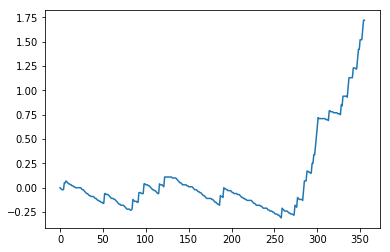

In [52]:
import matplotlib.pyplot as plt
plt.plot(range(0,713//2),lst)